# ANNEX A 
# Data processing and feature engineering

This notebook describes the preprocessing/features engineering which is done on the raw data of the titanic dataset. The data are from the kaggle challenge "Titanic: Machine Learning from Disaster". Some data are missing, the features are hardly relevant...These data are not really useful as they are provided. Therefore many challengers suggested to perform some features engineering first, to increase the efficiency of the models.

As our main interested is not in getting the maximal score, but demonstrated the faisability of a full-privacy-preserving method based on homomorphic encryption, I did not spend a lot of time on data completion and feature engineering. The method developed below is widely inspired from other challengers' methods which are referenced in the notebook. 

## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

## Setting Parameters

In [3]:
DATA_PATH="../data/raw/"
WRITE_PATH = "../data/processed/"

In [4]:
train_set_df = pd.read_csv(DATA_PATH + "train.csv")
test_set_df = pd.read_csv(DATA_PATH + "test.csv")
train_set_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We decide to performe data completion, and features engineering on all the data we have, without making any distiction between the test and train dataset. It is a contestable decision, as we will use the test set for data processing, so a bias will be introduced in the model evalation. However, the decision is motivated with a regard to the dataset size, which is really small. The idea is to works on a more representative dataset to process the data.  

In [5]:
all_data_df=pd.concat([train_set_df,test_set_df], sort=True).reset_index(drop=True)
all_data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## Missing values

The first issue to tackle is the lack of some values in the dataset. 

In [7]:
print('Training Set\n')
print(all_data_df.isnull().sum())
print('-'*40)
print('Test Set\n')
print(test_set_df.isnull().sum())

Training Set

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64
----------------------------------------
Test Set

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


We first look at the correlations between features, looking for some models which can use to predict the missing values, by interpolations. Here by default, we seek for linear models. 

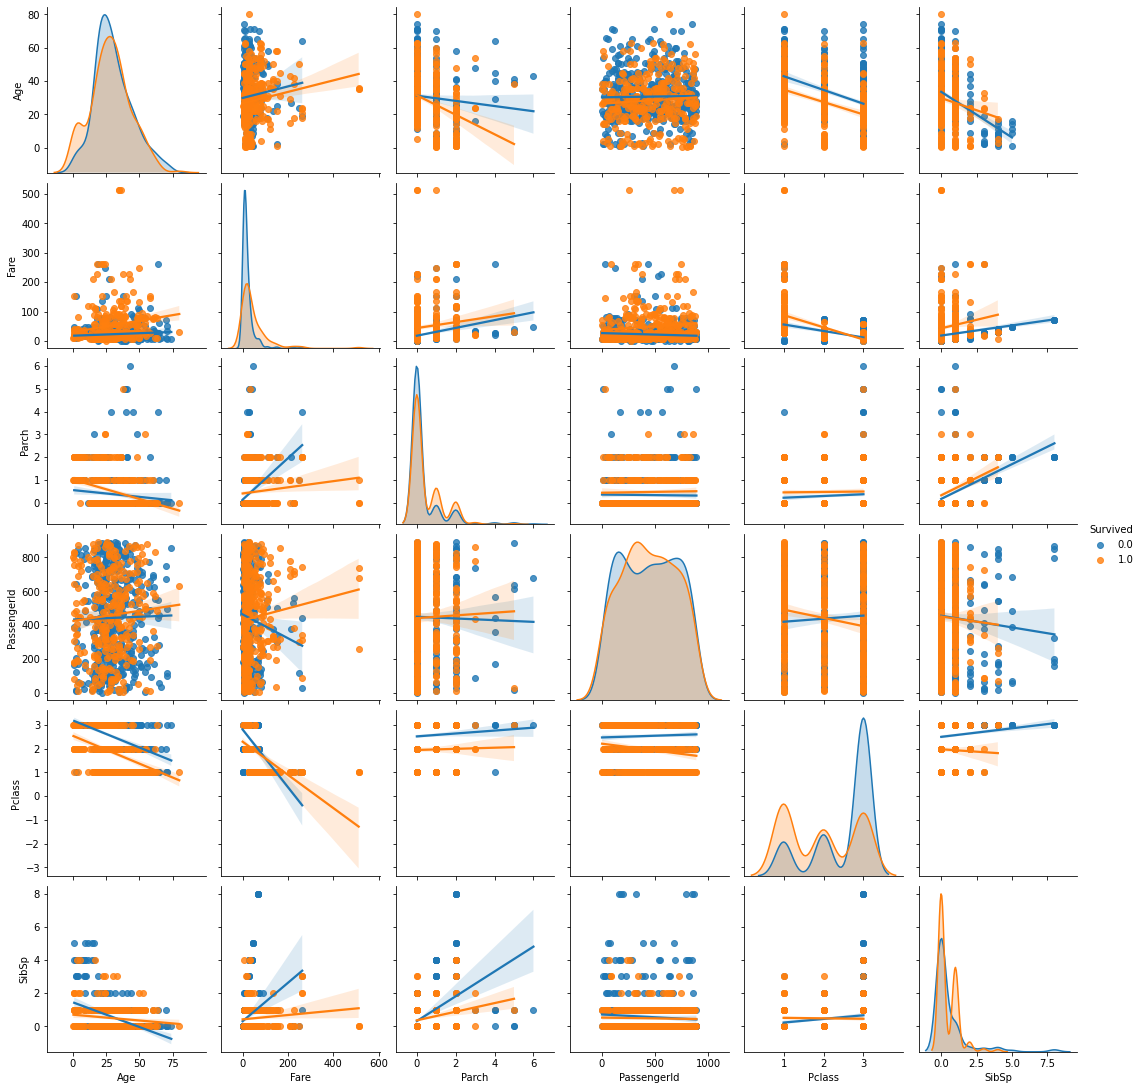

In [6]:
sns.pairplot(all_data_df, hue = 'Survived', kind='reg', diag_kind='kde')

Thanks to Güneş Evitan's efforts here: https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#1.-Exploratory-Data-Analysis

    When I googled Stone, Mrs. George Nelson (Martha Evelyn), I found that she embarked from S (Southampton) with her maid Amelie Icard, in this page Martha Evelyn Stone: Titanic Survivor.

We know that two missing values are actually S. Lets fill those.

In [8]:
all_data_df.Embarked = all_data_df.Embarked.fillna('S')
all_data_df.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

For Age and Fare, we are going to fit two multivariated linear regression on the test set, before using them to predict the missing ages and fare

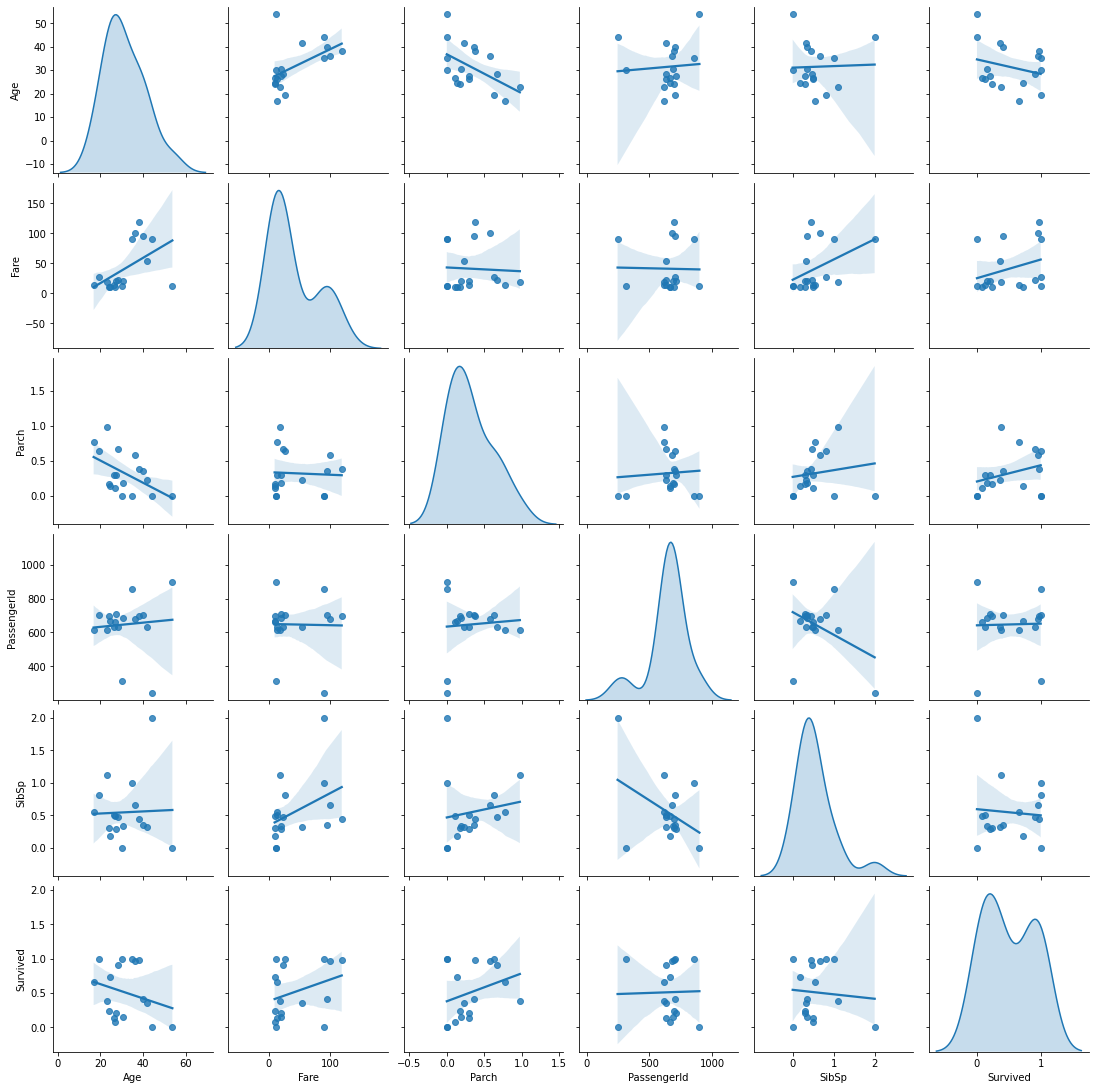

In [9]:
sns.pairplot(all_data_df.groupby(['Sex', 'Pclass','Embarked']).mean(),kind='reg', diag_kind='kde')

Finally regressions seem not really relevant... The solution suggested at https://www.kaggle.com/elifapaydn/logistic-regression-with-titanic-data looks quite relevant and shown good results.

In [10]:
all_data_df["Age"]=all_data_df.groupby(['Sex','Pclass','Embarked'])["Age"].apply(lambda x : x.fillna(x.median()))
all_data_df.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

The identical idea is developed for Fare

In [11]:
all_data_df.groupby(['Pclass', 'Parch']).median().Fare

Pclass  Parch
1       0         52.00000
        1         80.75415
        2        134.50000
        3        262.37500
        4        263.00000
2       0         13.00000
        1         26.00000
        2         30.00000
        3         23.00000
3       0          7.89580
        1         15.90000
        2         27.90000
        3         34.37500
        4         26.68335
        5         31.33125
        6         46.90000
        9         69.55000
Name: Fare, dtype: float64

In [12]:
all_data_df.Fare=all_data_df.Fare.fillna(all_data_df.groupby(['Pclass', 'Parch']).median().Fare[3][0])
all_data_df.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

At this point, remains the problem of missing cabine numbers.
We use the solution to classified peaple by desks, suggested and detailled here : https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#1.-Exploratory-Data-Analysis
For those where the cabin number is not specified, we create a "M" deck label, for missing. 
More details are provided by the author.

In [13]:
all_data_df['Deck'] = all_data_df.Cabin.fillna('M').apply(lambda x : str(x)[0])
all_data_df.groupby(['Deck','Pclass']).Pclass.count()

Deck  Pclass
A     1          22
B     1          65
C     1          94
D     1          40
      2           6
E     1          34
      2           4
      3           3
F     2          13
      3           8
G     3           5
M     1          67
      2         254
      3         693
T     1           1
Name: Pclass, dtype: int64

In [14]:
df = pd.DataFrame(all_data_df.groupby(['Deck']).Survived.sum())
df['Count'] = all_data_df.groupby(['Deck']).Survived.count()
df

,Survived,Count
Deck,,
A,7.0,15
B,35.0,47
C,35.0,59
D,25.0,33
E,24.0,32
F,8.0,13
G,2.0,4
M,206.0,687
T,0.0,1


In [15]:
all_data_df.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Deck              0
dtype: int64

Even if the cabin feature still contains null values, we will drop it later, and will only use the deck feature.

## Features engineering

Now that we filled the missing values, we can do better, and add some relevant features, built from the original one. 

We first add the feature Family_Size, built from the SibSp, and Parch.  

In [16]:
all_data_df['Family_Size'] = all_data_df['SibSp'] + all_data_df['Parch'] + 1
all_data_df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Family_Size
0,22.00,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2
1,38.00,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,2
2,26.00,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1
3,35.00,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,2
4,35.00,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.00,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,M,1
1305,39.00,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,C,1
1306,38.50,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,M,1
1307,25.00,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,M,1


We also use the feature Title, which will reavel insides on the social background, the wellfare, and so on.
It allow use to use the native feature Name, and it is inspired from https://www.kaggle.com/elifapaydn/logistic-regression-with-titanic-data

In [17]:
all_data_df['Title']=all_data_df.Name.str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.replace(" ","")

all_data_df['Title'] = all_data_df['Title'].replace(['Lady', 'theCountess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data_df['Title'] = all_data_df['Title'].replace('Mlle', 'Miss')
all_data_df['Title'] = all_data_df['Title'].replace('Ms', 'Miss')
all_data_df['Title'] = all_data_df['Title'].replace('Mme', 'Mrs')

## Encoding the data
We will use logisitic regression, so we want to work only with number. So we encode the unnumerical features with numbers. Moreover, for categorical features, we create as many features as possible classes, and use the labels 0 or 1 in these 'class-features'. 

In [18]:
all_data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Family_Size,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,2,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,2,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1,Mr


In [19]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   object 
 3   Fare         1309 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
 12  Deck         1309 non-null   object 
 13  Family_Size  1309 non-null   int64  
 14  Title        1309 non-null   object 
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


In [20]:
pd.get_dummies(all_data_df.Deck, prefix="Deck")

,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1304,0,0,0,0,0,0,0,1,0
1305,0,0,1,0,0,0,0,0,0
1306,0,0,0,0,0,0,0,1,0
1307,0,0,0,0,0,0,0,1,0


In [21]:
categorical_col = ["Pclass",'Embarked','SibSp','Deck', "Title"]
numerical_col = ["Age", "Fare", "Parch", "Family_Size"]

all_data_df.Sex = LabelEncoder.fit_transform(all_data_df.Sex, all_data_df.Sex)

for col in categorical_col:
    dummies = pd.get_dummies(all_data_df[col], prefix=col)
    all_data_df = pd.concat([all_data_df, dummies], axis=1)
    all_data_df = all_data_df.drop(col , axis=1)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           1309 non-null   float64
 1   Cabin         295 non-null    object 
 2   Fare          1309 non-null   float64
 3   Name          1309 non-null   object 
 4   Parch         1309 non-null   int64  
 5   PassengerId   1309 non-null   int64  
 6   Sex           1309 non-null   int32  
 7   Survived      891 non-null    float64
 8   Ticket        1309 non-null   object 
 9   Family_Size   1309 non-null   int64  
 10  Pclass_1      1309 non-null   uint8  
 11  Pclass_2      1309 non-null   uint8  
 12  Pclass_3      1309 non-null   uint8  
 13  Embarked_C    1309 non-null   uint8  
 14  Embarked_Q    1309 non-null   uint8  
 15  Embarked_S    1309 non-null   uint8  
 16  SibSp_0       1309 non-null   uint8  
 17  SibSp_1       1309 non-null   uint8  
 18  SibSp_2       1309 non-null 

We finally got our data processed, we drop the useless columns

In [22]:
all_data_df.drop(['Name','Cabin','Ticket', "PassengerId"], axis='columns', inplace=True)
all_data_df.head()

,Age,Fare,Parch,Sex,Survived,Family_Size,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,22.0,7.2500,0,1,0.0,2,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,38.0,71.2833,0,0,1.0,2,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,26.0,7.9250,0,0,1.0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,35.0,53.1000,0,0,1.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,35.0,8.0500,0,1,0.0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


We will use the homomorphic encryption scheme CKKS for ensure private computaitons. As this scheme allows only multipliaction and additon, we have to approximate non-linear function (as sigmoid and log) with polynomials. We use a minmax approximation, which is developed in the notebook XX. 
The sigmoid approximation is relevant between -5 and 5. To ensure that we stay between these values, we normalize all the features. 

In [23]:
col_to_reg = ['Age' , 'Fare', 'Family_Size']
for col in col_to_reg:
    all_data_df[col] = (all_data_df[col] - all_data_df[col].mean())/all_data_df[col].std()

In [24]:
all_data_df

,Age,Fare,Parch,Sex,Survived,Family_Size,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.542485,-0.502981,0,1,0.0,0.073324,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0.662414,0.734529,0,0,1.0,0.073324,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,-0.241260,-0.489936,0,0,1.0,-0.558133,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,0.436496,0.383118,0,0,1.0,0.073324,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.436496,-0.487520,0,1,0.0,-0.558133,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,-0.316566,-0.487520,0,1,NaN,-0.558133,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1305,0.737720,1.461511,0,0,NaN,-0.558133,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1306,0.700067,-0.502981,0,1,NaN,-0.558133,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1307,-0.316566,-0.487520,0,1,NaN,-0.558133,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## Saving the preprocessed data

In [25]:
train_set_df=all_data_df.iloc[:train_set_df.shape[0]]
test_set_df=all_data_df.iloc[train_set_df.shape[0]:].drop('Survived',axis=1)

train_set_df.to_csv(WRITE_PATH + "processed_train.csv")
test_set_df.to_csv(WRITE_PATH + "processed_test.csv")